Resources:

http://forums.fast.ai/t/fastai-for-image-captioning/17003/8

https://github.com/githubharald/SimpleHTR/blob/master/src/DataLoader.py

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.fastai.conv_learner import *
from fastai.fastai.text import *

In [3]:
PATH = Path('data/IAM_handwriting')
TMP_PATH = PATH/'tmp'

In [4]:
!ls {PATH}

ascii           line_labels.csv models          tmp             words
forms           lines           sentences       word_labels.csv words.csv


In [5]:
from PIL import Image

def open_image(fname):
    f = fname if fname.endswith('.png') else fname+'.png'
    return Image.open(f'{PATH}/words/{f}')

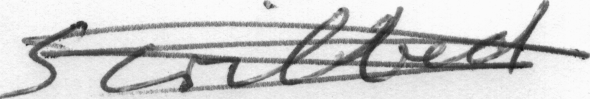

In [6]:
open_image('p06-047-08-00')

# Words

### Explore Data

In [18]:
# https://github.com/githubharald/SimpleHTR/blob/master/src/Model.py
    
imgSize = (128, 32)
maxTextLen = 32
samples = []
chars = set()

f=open(f'{PATH}/ascii/words.txt')
for line in f:
    # ignore comment line
    if not line or line[0]=='#':
        continue

    lineSplit = line.strip().split(' ')
    assert len(lineSplit) >= 9

    fileName = lineSplit[0]

    # GT text are columns starting at 9
    gtText = ''.join(lineSplit[8:])[:maxTextLen]
    chars = chars.union(set(list(gtText)))

    # put sample into list
    samples.append([fileName, gtText])

In [19]:
data = np.stack(samples)
data.shape

(115320, 2)

In [61]:
data[:,1]

array(['A', 'MOVE', 'to', ..., 'the', 'garden', '?'],
      dtype='<U32')

In [20]:
len(chars)

78

### DataFrame (word images)

In [7]:
word_labels = pd.read_csv(f'{PATH}/ascii/words.txt', delim_whitespace=True, comment="#", header=None, usecols=range(0, 9))

In [8]:
word_labels.columns = ['filename','result','graylevel','x','y','w','h','tag','value']

In [10]:
word_labels.tail()

,filename,result,graylevel,x,y,w,h,tag,value
75599,r06-143-04-06,ok,186,1323,1428,64,77,PP3O,him
75600,r06-143-04-07,ok,186,1458,1469,36,52,IN,in
75601,r06-143-04-08,ok,186,1532,1445,73,72,ATI,the
75602,r06-143-04-09,ok,186,1654,1444,199,114,NN,garden
75603,r06-143-04-10,ok,186,1892,1453,36,66,?,?


In [ ]:
samp = word_labels.sample(8)
info = {f'{PATH}words/{r.filename}.png': r.value for i,r in samp.iterrows()}

fnames = list(info.keys())
titles = list(info.values())

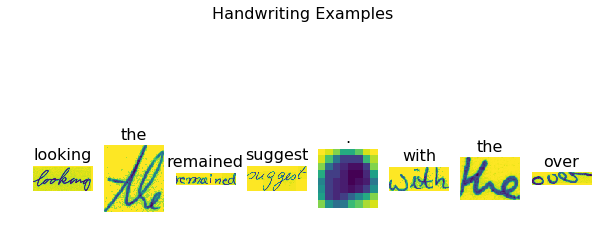

In [11]:
from fastai.fastai.plots import *

plots_from_files(fnames, titles=titles, maintitle="Handwriting Examples")

### check errors -> look OK

In [12]:
errors = word_labels[word_labels.result == 'err']

In [21]:
samp = errors.sample(8)
info = {f'{PATH}/words/{r.filename}.png': r.value for i,r in samp.iterrows()}

fnames = list(info.keys())
titles = list(info.values())

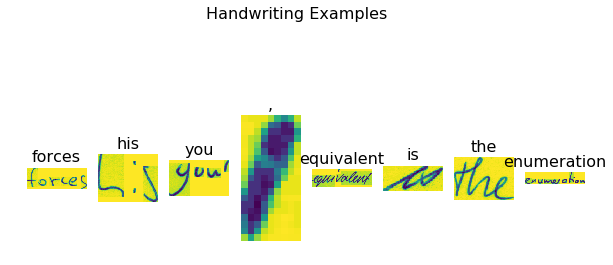

In [22]:
from fastai.fastai.plots import *

plots_from_files(fnames, titles=titles, maintitle="Handwriting Examples")

In [8]:
len(word_labels[word_labels.result == 'err']), len(word_labels)

(10847, 75604)

In [9]:
# remove all err results
# word_labels = word_labels[word_labels.result != 'err']
# len(word_labels)

64757

### Remove all rows where value count < 20 (word images)

In [10]:
# sort by label count
pivot = word_labels.pivot_table(index='value', aggfunc=len).sort_values('filename', ascending=False)
len(pivot)  # total num unique words

9685

In [11]:
# only keep values with counts > 20
pivot = pivot[pivot.filename > 20]
len(pivot)  # 344 unique words seen more than 20 times

344

In [12]:
value_mask = np.array(pivot.index)
value_mask

array(['the', ',', '.', 'of', 'to', 'and', 'a', 'in', 'that', 'was', 'is', 'for', 'he', 'had', 'be', 'with',
       'as', 'I', 'on', 'it', 'his', 'The', "'", 'by', 'at', 'not', 'which', 'but', 'have', 'are', 'been',
       'an', 'this', 'from', 'has', 'Mr.', 'were', '-', 'or', 'we', 'will', 'who', 'you', 'He', 'they',
       'would', 'their', 'It', 'her', 'more', 'all', 'so', '!', 'than', 'being', ';', 'one', 'there', 'him',
       'may', 'no', 'out', 'them', 'she', ':', 'In', 'first', 'man', 'when', 'said', 'about', 'up', 'A',
       'into', 'two', 'like', 'some', 'what', 'Anglesey', 'new', 'But', 'its', 'if', 'other', 'me', 'can',
       'very', 'Sir', 'my', 'much', 'people', '?', 'made', 'only', 'could', 'ever', 'our', 'years', 'great',
       'over', 'This', 'told', '...', 'should', '(', 'time', 'well', 'most', 'before', 'do', 'these', 'found',
       ')', 'under', 'year', 'now', 'even', 'And', 'must', 'life', 'per', 'back', 'God', 'any', 'then',
       'still', 'men', 'good', 'The

In [14]:
# apply value_mask to original csv
word_labels = word_labels[word_labels.value.isin(value_mask)]
len(word_labels)

41383

### Numericalize characters

In [21]:
itos = sorted(list(chars))
len(itos)

78

In [22]:
itos.insert(0, '_pad_')
itos.insert(1, '_unk_')

stoi = collections.defaultdict(lambda: 1, {v:k for k,v in enumerate(itos)})
ids = np.array([np.array([stoi[letter] for letter in word]) for word in data[:,1]])

In [63]:
ids

array([array([28]), array([40, 42, 49, 32]), array([73, 68]), ..., array([73, 61, 58]),
       array([60, 54, 71, 57, 58, 67]), array([27])], dtype=object)

In [111]:
# convert to strings (as labels)
strs = np.array([' '.join(str(l) for l in w) for w in ids])

In [81]:
ids.shape, data.shape, strs.shape

((115320,), (115320, 2), (115320,))

In [112]:
# need to make strs a 2d array to allow for concatenation onto data
z = strs.reshape(-1,1)

In [113]:
data = np.concatenate((data, z), axis=1)
data[:10]

array([['a01-000u-00-00', 'A', '28'],
       ['a01-000u-00-01', 'MOVE', '40 42 49 32'],
       ['a01-000u-00-02', 'to', '73 68'],
       ['a01-000u-00-03', 'stop', '72 73 68 69'],
       ['a01-000u-00-04', 'Mr.', '40 71 13'],
       ['a01-000u-00-05', 'Gaitskell', '34 54 62 73 72 64 58 65 65'],
       ['a01-000u-00-06', 'from', '59 71 68 66'],
       ['a01-000u-01-00', 'nominating', '67 68 66 62 67 54 73 62 67 60'],
       ['a01-000u-01-01', 'any', '54 67 78'],
       ['a01-000u-01-02', 'more', '66 68 71 58']],
      dtype='<U95')

In [114]:
# convert numpy array to dataframe
df = pd.DataFrame(data, columns=['filename', 'label', 'values'])
df.head()

,filename,label,values
0,a01-000u-00-00,A,28
1,a01-000u-00-01,MOVE,40 42 49 32
2,a01-000u-00-02,to,73 68
3,a01-000u-00-03,stop,72 73 68 69
4,a01-000u-00-04,Mr.,40 71 13


In [23]:
np.save(TMP_PATH/'word_ids.npy', ids)
pickle.dump(itos, open(TMP_PATH/'word_itos.pkl', 'wb'))

### Save to CSV

In [6]:
ids = np.load(TMP_PATH/'word_ids.npy')
itos = pickle.load(open(TMP_PATH/'word_itos.pkl', 'rb'))

In [7]:
CSV = f'{PATH}/words.csv'

In [48]:
# csv.to_csv(CSV, columns=['filename', 'values'], index=False)

In [8]:
csv = pd.read_csv(CSV)
csv.head()

,filename,values
0,a01-000u-00-00,28
1,a01-000u-00-01,40 42 49 32
2,a01-000u-00-02,73 68
3,a01-000u-00-03,72 73 68 69
4,a01-000u-00-04,40 71 13


In [9]:
len(csv)

115318

### Get val_idxs

In [10]:
val_idxs = np.array(csv.sample(frac=0.15).index)
len(val_idxs)

17298

### Preprocess (rotate, normalize)

In [11]:
f = resnet34
sz = 64
bs = 50

In [12]:
aug_tfms = [RandomRotate(5),  # transform type Classification
            RandomLighting(0.05, 0.05)]

tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
data = ImageClassifierData.from_csv(PATH, 'words', CSV, bs=bs, val_idxs=val_idxs,
                                    tfms=tfms, suffix='.png', continuous=True)

In [13]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

In [14]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.aug_dl))
x = denorm(x)

In [17]:
x.shape

(50, 64, 64, 3)

In [18]:
y.shape

torch.Size([50, 11])

### View image transforms

In [15]:
def label_text(pred):
    ints = to_np(pred).astype(int)
    ints = np.trim_zeros(ints)   # remove padding (0)
    return ''.join([itos[i] for i in ints])

In [101]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    if title: ax.set_title(title)
    return ax

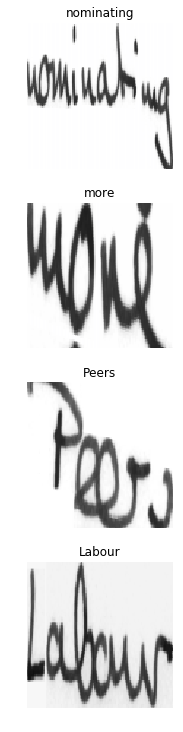

In [130]:
fig, axes = plt.subplots(4,1, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i])
#     t = data.classes[y[i]]
    ax=show_img(x[i], ax=ax, title=t)
    
plt.tight_layout(pad=0.1)

## Experiments

In [29]:
## taken from Translation notebook

class Seq2SeqRNN(nn.Module):
    def __init__(self, pre_enc, itos_enc, em_sz_enc, pre_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.nl,self.nh,self.out_sl = nl,nh,out_sl   #=> 2, 256, 30
        self.emb_enc = nn.Embedding.from_pretrained(pre_enc) #=> Embedding(24793, 300)
        # self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25) #=> ([300, 256, 2])
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        
        self.emb_dec = nn.Embedding.from_pretrained(pre_dec) #=> Embedding(17573, 300)
        # self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1) #=> ([300, 300, 2])
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec)) #=> ([300, 17573])
        self.out.weight.data = self.emb_dec.weight.data
        
    def forward(self, inp):        
        ### Encoder ###
        sl,bs = inp.size() #=> ([30, 125])
        # initialize previous hidden state - _bos_ tokens
        h = self.initHidden(bs) #=> ([2, 125, 256])
        # get input vectors from embedding and apply dropout
        emb = self.emb_enc_drop(self.emb_enc(inp)) #=> ([30, 125, 300])
        # run above through gru w/ previous hidden state
        enc_out, h = self.gru_enc(emb, h) #=> ([30, 125, 256]), ([2, 125, 256])
        # output vector to be fed to decoder
        h = self.out_enc(h) #=> ([2, 125, 300])
        
        # initialize decoder input - _bos_ tokens
        dec_inp = V(torch.zeros(bs).long()) #=> ([125])
        res = []
        # loop through ~30 times -> for each word in output
        for i in range(self.out_sl):
            # .unsqueeze(0) - add leading unit axis -> treat as a sequence of length 1
            # gru works on an entire sequence at a time but we're iterating through each part separately...
            # not really taking advantage of rnn at all; could re-write using linear layer
            # dec_inp - input to the embedding - previous result
            emb = self.emb_dec(dec_inp).unsqueeze(0)  # embedding => ([1, 125, 300])
            outp, h = self.gru_dec(emb, h)            # rnn => ([1, 125, 300]),  ([2, 125, 300])
            outp = self.out(self.out_drop(outp[0]))   # dropout, linear layer => ([125, 17571])
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])  #=> ([125])
            if (dec_inp==1).all(): break    # 1: padding token => stop, we're done (padding at the end)
        return torch.stack(res)   # stack up list of results into single tensor and return it
    
    def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))

In [48]:
# based on seq2seq translation - old version

class Seq2SeqCNN_RNN(nn.Module):
    def __init__(self, conv_model, vs, em_sz, nh, sl, nl=2):
        super().__init__()
        self.nl,self.nh,self.sl = nl,nh,sl   #=> 2, 128, 20
        
        self.shrink = nn.Conv2d(64,sl,1)
        self.av_pool = nn.AdaptiveAvgPool2d(8)
        self.out_enc = nn.Linear(8*8, em_sz)  # (?, 10)
                
        self.emb = nn.Embedding(vs, em_sz)  # ([80, 10])
        self.emb_drop = nn.Dropout(0.15)
        self.gru = nn.GRU(em_sz, em_sz, num_layers=sl, dropout=0.35) #=> ([10, 10, 20])

        self.out = nn.Linear(em_sz, vs) #=> ([10, 80])
        
    def forward(self, inp):
        ### Encoder (Conv Layer) ###        
        conv_feats = conv_model(inp)
        conv = self.av_pool(self.shrink(conv_feats))
        bs,c,h,w = conv.shape  #=> ([50, 20, 8, 8])
        
        reshape = conv.permute(1,0,2,3).contiguous().view(c, bs, -1)  #=> ([20, 50, 64])
       
        # output vector to be fed to decoder  (n_layers, rest)
        h = self.out_enc(reshape) #=> ([20, 50, 10])
        
        # initialize decoder input - 0s (could use teacher forcing here...)
        dec_inp = V(torch.zeros(bs).long()) #=> ([50])
        res = []
        
        ### DECODER LOOP ###    loop through ~20 times -> for each letter in output
        for i in range(self.sl):
            # .unsqueeze(0) - add leading unit axis -> treat as a sequence of length 1
            # gru works on an entire sequence at a time but we're iterating through each part separately...
            # not really taking advantage of rnn at all; could re-write using linear layer
            # dec_inp - input to the embedding - previous result
            emb = self.emb_drop(self.emb(dec_inp).unsqueeze(0))  # embedding => ([1, 50, 10])
                        
            outp, h = self.gru(emb, h)        # rnn => ([1, 50, 10]),  ([20, 50, 10])            
            outp = self.out(outp[0])          #=> ([50, 80])
            res.append(outp)
            # dec_inp = V(outp.data.max(1)[1])  #=> ([50])
            # if (dec_inp==0).all(): break      # 1: padding token => stop, we're done (padding at the end)
        return torch.stack(res)               # stack up list of results into single tensor and return it

In [33]:
feats = conv_model(T(x).permute(0,3,1,2))
feats.shape

torch.Size([50, 64, 16, 16])

In [32]:
# https://github.com/BelBES/crnn-pytorch/blob/master/models/crnn.py
# uses inputs of 320x32
# convert the width dimension into the sequence length; height must be 1 already!!

iden_conv = nn.Conv2d(16, 20, kernel_size=1)

f = feats.permute(0,3,2,1)
f = iden_conv(f)
f = f.permute(1, 0, 2, 3)
f.size() # ([20, 50, 16, 64]); 16 needs to be 1
# f = f.squeeze(2)

torch.Size([20, 50, 16, 64])

In [158]:
feats = feats.permute(0,2,3,1).contiguous().view(-1,64)

In [34]:
pool = nn.AdaptiveMaxPool2d((1,16))
res = pool(feats)
res.shape

torch.Size([50, 64, 1, 16])

In [159]:
lin = nn.Linear(64, 200)
res = lin(feats)
res.shape

torch.Size([625, 200])

## Seq2Seq

**GRU**

Inputs: input, h_0
    - **input** of shape `(seq_len, batch, input_size)`: tensor containing the features
      of the input sequence. The input can also be a packed variable length
      sequence. See :func:`torch.nn.utils.rnn.pack_padded_sequence`
      for details.
    - **h_0** of shape `(num_layers * num_directions, batch, hidden_size)`: tensor
      containing the initial hidden state for each element in the batch.
      Defaults to zero if not provided.

Outputs: output, h_n
    - **output** of shape `(seq_len, batch, hidden_size * num_directions)`: tensor
      containing the output features h_t from the last layer of the GRU,
      for each t. If a :class:`torch.nn.utils.rnn.PackedSequence` has been
      given as the input, the output will also be a packed sequence.
    - **h_n** of shape `(num_layers * num_directions, batch, hidden_size)`: tensor
      containing the hidden state for `t = seq_len`

In [25]:
def get_block_size(net):
    return net[-1][-1].bn2.weight.size()[0]

get_block_size(conv_model)

64

In [15]:
vs = len(itos)
conv_model = nn.Sequential(*children(f(True))[:5]) #=> feature map of shape: (bs, 64, 25, 25)

In [16]:
em_sz,nh,sl = 64,128,20

In [22]:
# based on CRNN - https://github.com/BelBES/crnn-pytorch/blob/master/models/crnn.py

class Seq2SeqCNN_RNN(nn.Module):
    def __init__(self, conv_model, vs, em_sz, nh, sl, nl=2):
        super().__init__()
        self.nl,self.nh,self.sl = nl,nh,sl   #=> 2, 128, 20
        
        self.pool = nn.AdaptiveMaxPool2d((1,16)) # (h,w)
        self.reshape = nn.Conv2d(16,sl,1)

        self.gru = nn.GRU(em_sz, em_sz, num_layers=nl, dropout=0.35, bidirectional=True)
        self.out = nn.Linear(em_sz*2, vs) #=> ([64, 80])
        
    def forward(self, inp):
        ### Encoder (Conv Layer) ###
        feats = conv_model(inp)        #=> ([50, 64, 16, 16])  (bs,c,h,w)
        feats = self.pool(feats)       #=> ([50, 64, 1, 16])
        feats = feats.permute(0,3,2,1) #=> ([50, 16, 1, 64])
        feats = self.reshape(feats)    #=> ([50, 20, 1, 64])
        feats = feats.permute(1,0,2,3).squeeze(2)
        sl,bs,c = feats.size() #=> ([20, 50, 64])
        
        ### Decoder (RNN Layer) ###
        hidden = self.initHidden(bs)
        outp, hidden = self.gru(feats, hidden)    #=> ([20, 50, 64]),  ([2, 50, 64])            
        return self.out(outp)                     #=> ([20, 50, 80])   
   
    def initHidden(self, bs): return V(torch.zeros(self.nl*2, bs, em_sz))

In [18]:
# categorical cross entropy loss
# list of probabilities for each character in vocab; target is correct character

def seq2seq_loss(input, target):
    targ = target.transpose(0,1).contiguous()  # need to switch the axes to line up
    sl,bs = targ.size()   #=> ([13,50])
    sl_in,bs_in,nc = input.size()  #=> ([20, 50, 80])
        
    # tweak 1: align sequence lengths (input is always 20 but target often is less)
    if sl_in>sl: targ = F.pad(targ, (0,0,0,sl_in-sl)) # rank2 tensor requires 4 padding values
    # (padLeft, padRight, padTop, padBottom) => (before 1, after 1, before 0, after 0)
    # sequence length: add as much padding as necessary at the end
    
    # input = input[:sl]
    targ = targ[:20,:].long()
    # cross_entropy expects rank2 tensor but we have sl * bs so we need to flatten out both
    # combination of LogSoftmax and NLLLoss
    return F.cross_entropy(input.view(-1,nc), targ.view(-1))  #=> ([1000, 80]), ([1000])

In [26]:
rnn = Seq2SeqCNN_RNN(conv_model, vs, em_sz, nh, sl)
# SingleModel => way to handle learning rate groups -> treats whole thing as single group
# easy way to turn pytorch module into fastai model
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss
learn.clip=10.
# learn.metrics = [accuracy]

In [27]:
learn.lr_find(start_lr=1e-4)
learn.sched.plot()

A Jupyter Widget

  2%|▏         | 41/1961 [00:31<24:30,  1.31it/s, loss=3.74]

KeyboardInterrupt: 

In [35]:
lr = 2e-4

### Determine size of dataset (300,125)

In [51]:
# create a dictionary comprehension of image sizes in the dataset
size_d = {k: PIL.Image.open(PATH+k).size for k in data.val_ds.fnames}

In [52]:
row_sz,col_sz = list(zip(*size_d.values()))

In [53]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

(array([ 2752.,  3277.,  2014.,  1023.,   406.,   168.,    49.,    18.,     4.,     3.]),
 array([   1. ,   85.1,  169.2,  253.3,  337.4,  421.5,  505.6,  589.7,  673.8,  757.9,  842. ]),
 <a list of 10 Patch objects>)

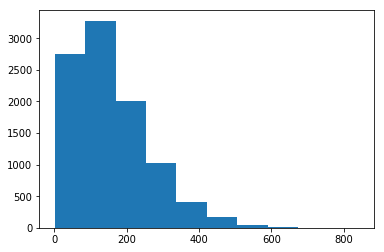

In [54]:
plt.hist(row_sz)

(array([  629.,  1338.,  2883.,  2678.,  1270.,   537.,   262.,    94.,    20.,     3.]),
 array([   1. ,   23.3,   45.6,   67.9,   90.2,  112.5,  134.8,  157.1,  179.4,  201.7,  224. ]),
 <a list of 10 Patch objects>)

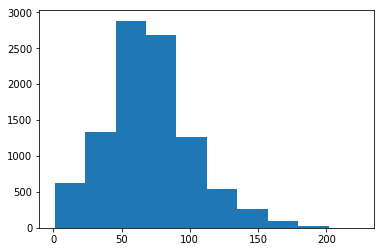

In [55]:
plt.hist(col_sz)

## Vanilla Resnet (word images)

In [10]:
learn = ConvLearner.pretrained(f, data, metrics=[accuracy])
learn.opt_fn = optim.Adam

In [27]:
learn.lr_find()

A Jupyter Widget

  0%|          | 1/550 [00:01<14:01,  1.53s/it, loss=6.68]  


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/Users/adamschiller/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/adamschiller/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/adamschiller/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 72%|███████▏  | 396/550 [06:06<02:22,  1.08it/s, loss=12.5]


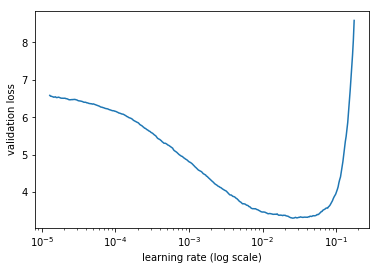

In [28]:
learn.sched.plot()

In [33]:
# min: 2e-4, max: 1e-2 => 1e-2/2e-4 = 50
lr = 1e-2
learn.fit(lr, 1, cycle_len=5, use_clr=(50,5))

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                   
    0      2.363408   1.935103   0.545191  
    1      1.931388   1.610802   0.594007                   
    2      1.669592   1.416459   0.629451                   
    3      1.526673   1.29501    0.65555                    
    4      1.36705    1.214377   0.676494                   



[1.2143766782278789, 0.67649428085253704]

In [34]:
learn.save('resnet_5')

# Lines

### Explore Data

In [6]:
line_labels = pd.read_csv(f'{PATH}/ascii/lines.txt', names=['filename','result','value'], escapechar='\\', delim_whitespace=True, skiprows=23, header=None, usecols=[0,1,8])

In [7]:
line_labels.tail()

,filename,result,value
13346,r06-143-00,ok,In|the|train|going|back|to|London|I|sat
13347,r06-143-01,ok,beside|#|Catherine|.|She|had|the|stories|open
13348,r06-143-02,ok,"in|front|of|her|,|but|she|said|:|'|Philip|'s|a..."
13349,r06-143-03,ok,I|wish|I|went|to|that|school|.|Did|you|notice
13350,r06-143-04,ok,that|girl|who|said|hullo|to|him|in|the|garden|?


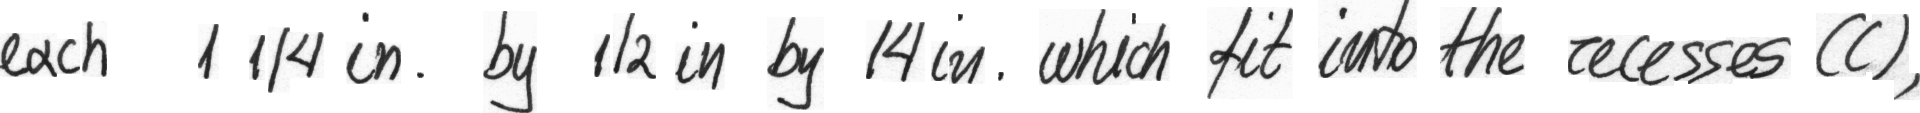

In [8]:
open_image('e04-008-03')

In [9]:
line_labels['text'] = line_labels.apply(lambda row: row.value.replace('|', ' '), axis=1)
line_labels.tail()

,filename,result,value,text
13346,r06-143-00,ok,In|the|train|going|back|to|London|I|sat,In the train going back to London I sat
13347,r06-143-01,ok,beside|#|Catherine|.|She|had|the|stories|open,beside # Catherine . She had the stories open
13348,r06-143-02,ok,"in|front|of|her|,|but|she|said|:|'|Philip|'s|a...","in front of her , but she said : ' Philip 's a..."
13349,r06-143-03,ok,I|wish|I|went|to|that|school|.|Did|you|notice,I wish I went to that school . Did you notice
13350,r06-143-04,ok,that|girl|who|said|hullo|to|him|in|the|garden|?,that girl who said hullo to him in the garden ?


### Tokenize Labels

In [10]:
tokens = Tokenizer().proc_all_mp(partition_by_cores(line_labels.text))

In [11]:
np.argmax([len(o) for o in tokens])

4964

In [12]:
tokens[4964], len(tokens[4964])

(['each',
  '1',
  '1',
  '/',
  '4',
  'in',
  '.',
  'by',
  '1',
  '/',
  '2',
  'in',
  '.',
  'by',
  '14',
  'in',
  '.',
  'which',
  'fit',
  'into',
  'the',
  'recesses',
  '(',
  'c',
  ')',
  ','],
 26)

In [13]:
np.percentile([len(o) for o in tokens], 99)

16.0

### Numericalize Labels

In [15]:
freq = Counter(word for line in tokens for word in line)
freq.most_common(25)

[('the', 6491),
 ('.', 5561),
 (',', 5558),
 ('of', 3221),
 ('to', 2708),
 ('and', 2615),
 ('a', 2429),
 ('in', 2044),
 ('"', 1601),
 ('he', 1210),
 ('that', 1187),
 ('was', 1154),
 ('-', 1112),
 ('is', 1004),
 ('it', 983),
 ("'", 977),
 ('for', 890),
 ('as', 771),
 ('with', 766),
 ('his', 761),
 ('i', 746),
 ('had', 742),
 ('be', 731),
 ('on', 729),
 ("'s", 629)]

In [16]:
max_vocab=40000
min_freq=2

In [47]:
itos = [word for word,count in freq.most_common(max_vocab) if count>min_freq]
itos.insert(0, '_unk_')
itos.insert(1, '_pad_')

stoi = collections.defaultdict(lambda: 0, {v:k for k,v in enumerate(itos)})
ids = np.array([np.array([stoi[word] for word in line]) for line in tokens])

In [18]:
len(ids), len(itos), len(stoi)

(13351, 4085, 11704)

In [128]:
def idstoline(ids):
    return ' '.join(itos[i] for i in ids)

In [129]:
idstoline(ids[0])

'a t_up move to stop mr . gaitskell from'

In [22]:
np.save(TMP_PATH/'ids.npy', ids)
pickle.dump(itos, open(TMP_PATH/'itos.pkl', 'wb'))

In [8]:
ids = np.load(TMP_PATH/'ids.npy')
itos = pickle.load(open(TMP_PATH/'itos.pkl', 'rb'))

In [73]:
# add ids to df
line_labels['ids'] = [' '.join(str(p) for p in o) for o in ids]
line_labels.tail()

,filename,result,value,text,ids
13346,r06-143-00,ok,In|the|train|going|back|to|London|I|sat,In the train going back to London I sat,9 2 871 159 116 6 200 22 712
13347,r06-143-01,ok,beside|#|Catherine|.|She|had|the|stories|open,beside # Catherine . She had the stories open,1392 143 1299 3 44 23 2 2316 506
13348,r06-143-02,ok,"in|front|of|her|,|but|she|said|:|'|Philip|'s|a...","in front of her , but she said : ' Philip 's a...",9 1003 5 35 4 28 44 55 77 17 832 26 0 2303 3
13349,r06-143-03,ok,I|wish|I|went|to|that|school|.|Did|you|notice,I wish I went to that school . Did you notice,22 1115 22 164 6 12 397 3 107 33 436
13350,r06-143-04,ok,that|girl|who|said|hullo|to|him|in|the|garden|?,that girl who said hullo to him in the garden ?,12 235 52 55 0 6 59 9 2 1431 57


### load Wikitext103 pretrained model

In [23]:
pre_path = Path('data/aclImdb/models/wt103')
pre_lm_path = pre_path/'fwd_wt103.h5'

In [24]:
wgts = torch.load(pre_lm_path, map_location=lambda storage, loc: storage )

In [25]:
dec_wgts = to_np(wgts['1.decoder.weight'])
row_mean = dec_wgts.mean(0)
dec_wgts.shape

(238462, 400)

In [26]:
wiki_itos = pickle.load((pre_path/'itos_wt103.pkl').open('rb'))
wiki_stoi = collections.defaultdict(lambda: -1, {v:k for k,v in enumerate(wiki_itos)})

In [27]:
def create_emb(dec_wgts, itos, em_sz):
    row_mean = torch.from_numpy(dec_wgts.mean(0))
    # embedding: simple lookup table - input=index; output=word vector
    # embeddings: rows = vocab size (4085), columns = determined by wiki pre-trained weights (400)
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    # learnable pytorch module has a 'weight' attribute => Variable
    # 'weight' attribute has a 'data' attribute => Tensor
    wgts = emb.weight.data
    # iterate through vocabulary and replace found words w/ pretrained vector weights if available
    for idx,word in enumerate(itos):
        wiki_int = wiki_stoi[word]
        wgts[idx] = torch.from_numpy(dec_wgts[wiki_int]) if wiki_int >= 0 else row_mean
    
    return emb

In [55]:
emb_dec = create_emb(dec_wgts, itos, em_sz)

AttributeError: 'collections.OrderedDict' object has no attribute 'size'

In [29]:
torch.save(emb_dec, TMP_PATH/'embedding_decoder.h5')

In [53]:
emb_dec = torch.load(TMP_PATH/'embedding_decoder.h5')

In [34]:
wgts['0.encoder.weight'] = T(new_w)
# weight tying
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

In [35]:
torch.save(wgts, TMP_PATH/'pretrained.h5')

In [19]:
wgts = torch.load(TMP_PATH/'pretrained.h5')
dec_wgts = to_np(wgts['1.decoder.weight'])

### Save DF as CSV

In [61]:
CSV = PATH/'line_labels.csv'

In [74]:
line_labels.to_csv(CSV, columns=['filename', 'ids'], index=False)

In [75]:
csv = pd.read_csv(CSV)
csv.head()

,filename,ids
0,a01-000u-00,8 31 1310 6 499 40 3 948 38
1,a01-000u-01,0 110 64 161 120 1311
2,a01-000u-02,15 6 24 103 27 8 386 5 161
3,a01-000u-03,893 500 3 40 3 1622 833 45
4,a01-000u-04,204 135 8 2147 25 2 707


In [12]:
len(csv)

13351

In [76]:
CSV.open().readlines()[:5]

['filename,ids\n',
 'a01-000u-00,8 31 1310 6 499 40 3 948 38\n',
 'a01-000u-01,0 110 64 161 120 1311\n',
 'a01-000u-02,15 6 24 103 27 8 386 5 161\n',
 'a01-000u-03,893 500 3 40 3 1622 833 45\n']

### Get val_idxs

In [77]:
val_idxs = np.array(csv.sample(frac=0.15).index)
len(val_idxs)

2003

### Model Data (rotate, normalize)

In [220]:
sz = 500
bs = 50

In [221]:
# use this md object to load image data w/ transforms

# These values were generated initially with tfms_from_model(resnet34)
stats = A([ 0.92025,  0.92025,  0.92025], [ 0.12774,  0.12774,  0.12774])

# aug_tfms = [RandomRotate(5), RandomLighting(0.1, 0.1)]

tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, aug_tfms=RandomLighting(0.1, 0.1))
data = ImageClassifierData.from_csv(PATH, 'lines', CSV, val_idxs=val_idxs, tfms=tfms, suffix='.png',
                                    continuous=True)

**Dataset**
- x: images (with aug_tfms)
- y: array of ints -> represent words in a line
    -- pre_pad=False, pad_idx=1, transpose_y=?????

In [222]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

data.aug_dl.pad_idx=1
data.trn_dl.pad_idx=1
data.val_dl.pad_idx=1

In [223]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.aug_dl))
x = denorm(x)

In [206]:
ints = to_np(y[7]).astype(int)
idstoline(ints)

'labour has to have an adequate number _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_'

In [207]:
x[7].shape

(200, 200, 3)

### View image transforms

In [208]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    if title: ax.set_title(title)
    return ax

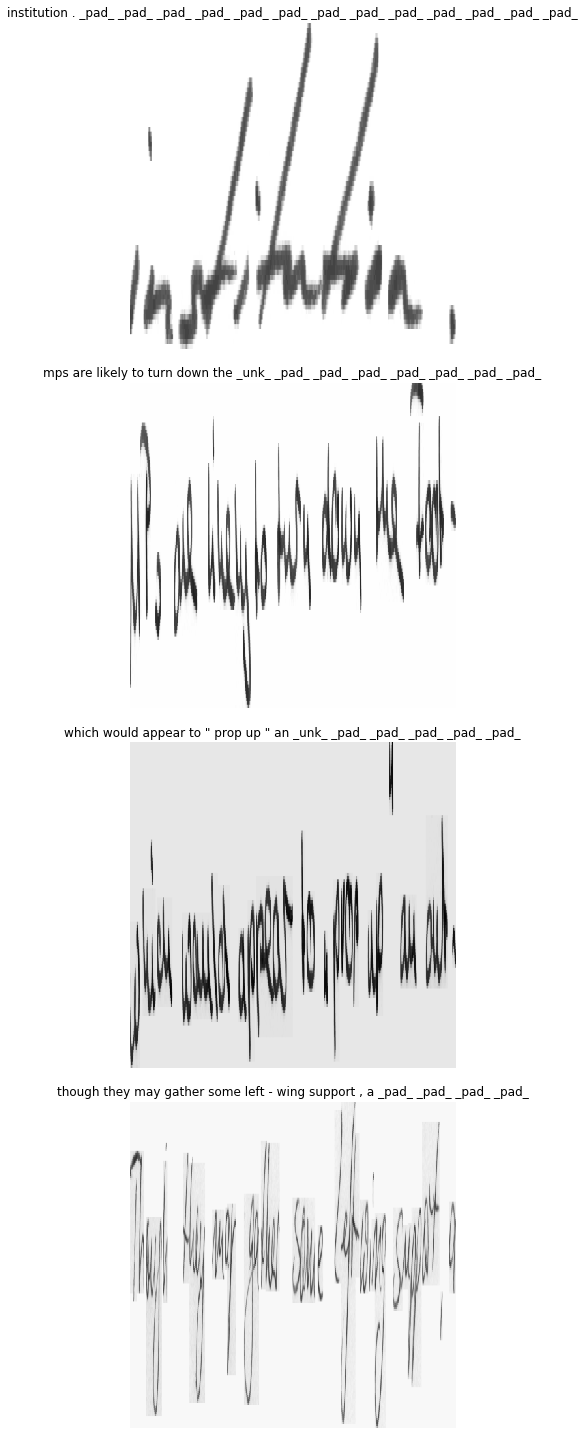

In [225]:
fig, axes = plt.subplots(4,1, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    ints = to_np(y[i]).astype(int)
    t = idstoline(ints)
#     t = data.classes[y[i]]
    ax=show_img(x[i], ax=ax, title=t)
    
plt.tight_layout(pad=0.1)

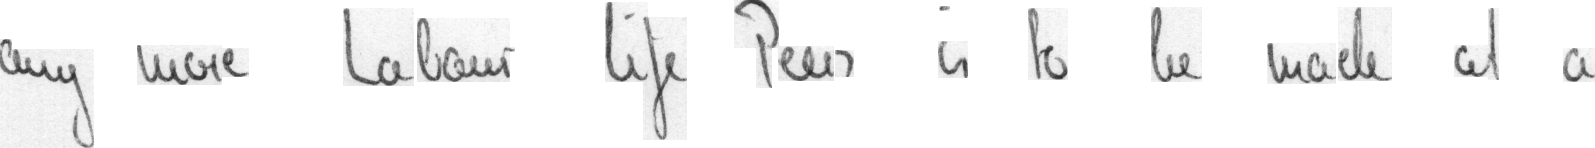

In [141]:
Image.open(PATH/md.trn_ds.fnames[8])

In [139]:
from fastai.fastai.plots import *

def show_augs(n):
    x,_ = next(iter(data.aug_dl))
    x = data.trn_ds.denorm(x)[n]
    return plots(x, rows=1)

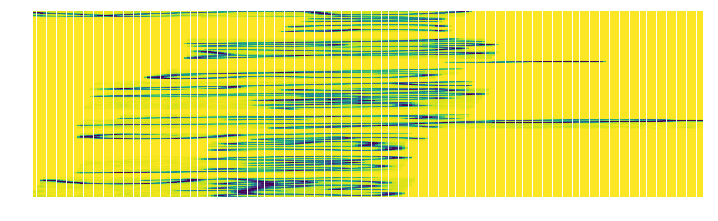

In [140]:
show_augs(8)

### Determine size of dataset (2000 x 200)

In [61]:
# create a dictionary comprehension of image sizes in the dataset
size_d = {k: PIL.Image.open(PATH/k).size for k in data.val_ds.fnames}

In [62]:
row_sz,col_sz = list(zip(*size_d.values()))

In [63]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

(array([    9.,    16.,    25.,    21.,    27.,    27.,   116.,  1075.,   625.,    62.]),
 array([  100. ,   313.3,   526.6,   739.9,   953.2,  1166.5,  1379.8,  1593.1,  1806.4,  2019.7,  2233. ]),
 <a list of 10 Patch objects>)

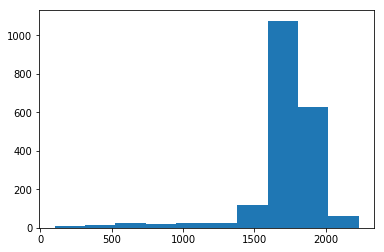

In [64]:
plt.hist(row_sz)

(array([  86.,  429.,  699.,  464.,  224.,   82.,   15.,    2.,    1.,    1.]),
 array([  45. ,   72.5,  100. ,  127.5,  155. ,  182.5,  210. ,  237.5,  265. ,  292.5,  320. ]),
 <a list of 10 Patch objects>)

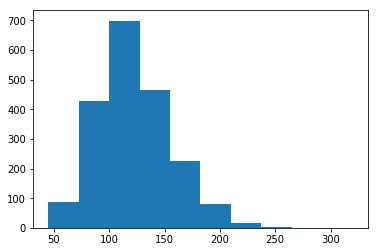

In [65]:
plt.hist(col_sz)

## Initial Seq2Seq

In [40]:
vs = len(itos)
f = resnet34
conv_model = nn.Sequential(*children(f(True))[:5]) #=> feature map of shape: (bs, 64, 16, 16)

In [33]:
z = conv_model(T(x).permute(0,3,1,2))

In [34]:
z.shape

torch.Size([64, 64, 16, 16])

In [35]:
z.view(64, 64, -1).shape

torch.Size([64, 64, 256])

**GRU**

Inputs: input, h_0
    - **input** of shape `(seq_len, batch, input_size)`: tensor containing the features
      of the input sequence. The input can also be a packed variable length
      sequence. See :func:`torch.nn.utils.rnn.pack_padded_sequence`
      for details.
    - **h_0** of shape `(num_layers * num_directions, batch, hidden_size)`: tensor
      containing the initial hidden state for each element in the batch.
      Defaults to zero if not provided.

Outputs: output, h_n
    - **output** of shape `(seq_len, batch, hidden_size * num_directions)`: tensor
      containing the output features h_t from the last layer of the GRU,
      for each t. If a :class:`torch.nn.utils.rnn.PackedSequence` has been
      given as the input, the output will also be a packed sequence.
    - **h_n** of shape `(num_layers * num_directions, batch, hidden_size)`: tensor
      containing the hidden state for `t = seq_len`

In [46]:
em_sz,nh,nl = 400,256,2

In [47]:
class Seq2SeqCNN_RNN(nn.Module):
    def __init__(self, conv_model, emb_dec, vs, em_sz, nh, out_sl, nl=2):
        super().__init__()
        self.nl,self.nh,self.out_sl = nl,nh,out_sl   #=> 2, 256, 20
        
        self.out_enc = nn.Linear(nh, em_sz, bias=False)  # (256, 400)
        
        #self.emb = emb_dec
        self.emb_drop = nn.Dropout(0.15)
        self.gru = nn.GRU(em_sz, em_sz, num_layers=out_sl, dropout=0.35) #=> ([400, 400, 20])

        self.out = nn.Linear(em_sz, vs) #=> ([400, 4085])
        self.out.weight.data = emb_dec.weight.data
        
    def forward(self, inp):        
        ### Encoder (Conv Layer) ###
        
        conv_feats = conv_model(inp)  #=> ([64(bs), 16(h), 16(w), 64(c)])
        # reshape conv_feats to feed into gru
        reshape = conv_feats.permute(0,3,1,2).contiguous().view(64, 64, -1) #=> ([64, 64, 256])
        
        # output vector to be fed to decoder  (n_layers, rest)
        h = self.out_enc(reshape) #=> ([64, 64, 400])
        
        pdb.set_trace()
        #GRU inputs: (([1, 64, 400]), ([2, 64, 400]))

        # initialize decoder input - 0s (could use teacher forcing here...)
        dec_inp = V(torch.zeros(bs).long()) #=> ([64])
        res = []
         
        ### DECODER LOOP ###    loop through ~20 times -> for each word in output
        for i in range(self.out_sl):
            # .unsqueeze(0) - add leading unit axis -> treat as a sequence of length 1
            # gru works on an entire sequence at a time but we're iterating through each part separately...
            # not really taking advantage of rnn at all; could re-write using linear layer
            # dec_inp - input to the embedding - previous result
            emb = self.emb_drop(emb_dec(dec_inp).unsqueeze(0))  # embedding => ([1, 64, 400])
            outp, h = self.gru(emb, h)        # rnn => ([1, 64, 400]),  ([64, 64, 400]) expected 20, got 64
            outp = self.out(outp[0])          # dropout, linear layer => ([64, 4085])
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])  #=> ([64])
            if (dec_inp==1).all(): break      # 1: padding token => stop, we're done (padding at the end)
        return torch.stack(res)               # stack up list of results into single tensor and return it
    
#     def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))

In [48]:
# categorical cross entropy loss
# list of probabilities for each word in vocab; target is correct word

def seq2seq_loss(input, target):    
    sl,bs = target.size()   #=> ([20,64])
    sl_in,bs_in,nc = input.size()  #=> ([20, 64, 17573])
    
    # tweak 1: we may have stopped early; if seq length is less than target, add some padding
    # necessary if difference in length btw target and input sl (french longer than english)
    if sl>sl_in: input = F.pad(input, (0,0,0,0,0,sl-sl_in)) # rank3 tensor requires 6 padding values (before and after)
    # 3rd dimension (sequence length??) add as much padding as necessary at the end
        
    input = input[:sl]
    # cross_entropy expects rank2 tensor but we have sl * bs so we need to flatten out both
    # combination of LogSoftmax and NLLLoss
    return F.cross_entropy(input.view(-1,nc), target.view(-1))  #=> ([3750, 17573]), ([3750])

In [49]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [50]:
rnn = Seq2SeqCNN_RNN(conv_model, emb_dec, vs, em_sz, nh, 20)
# SingleModel => way to handle learning rate groups -> treats whole thing as single group
# easy way to turn pytorch module into fastai model
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

In [51]:
learn.lr_find(start_lr=1e-7)
learn.sched.plot()

A Jupyter Widget

  0%|          | 0/178 [00:00<?, ?it/s]> <ipython-input-47-03c9d21b4d2d>(29)forward()
-> dec_inp = V(torch.zeros(bs).long()) #=> ([20, 64])
(Pdb) !h.shape
torch.Size([64, 64, 400])
(Pdb) reshape.shape
torch.Size([64, 64, 256])
(Pdb) n
> <ipython-input-47-03c9d21b4d2d>(30)forward()
-> res = []
(Pdb) dec_inp.shape
torch.Size([64])
(Pdb) n
> <ipython-input-47-03c9d21b4d2d>(33)forward()
-> for i in range(self.out_sl):
(Pdb) n
> <ipython-input-47-03c9d21b4d2d>(38)forward()
-> emb = self.emb_drop(emb_dec(dec_inp).unsqueeze(0))  # embedding => ([1, 64, 400])
(Pdb) l
 33  	        for i in range(self.out_sl):
 34  	            # .unsqueeze(0) - add leading unit axis -> treat as a sequence of length 1
 35  	            # gru works on an entire sequence at a time but we're iterating through each part separately...
 36  	            # not really taking advantage of rnn at all; could re-write using linear layer
 37  	            # dec_inp - input to the embedding - previous result
 38  ->	        

BdbQuit: 

In [ ]:
# spatial attention model